# Statistical Considerations in Testing

<!-- How do you deduce **causality**? *Run an experiment!*

Covered in this lesson:
1. [What is an expirement](#what_is)<br>

> 1.1 [1.1 What types of studies are there](#study_types)<br>

2. [What types of experiments are there](#types)<br>

> 2.1 [Types of Sampling](#sampling)<br>

3. [How are outcomes measured](#measured)<br>

> 3.1: [Creating Metrics](#met_create)<br>

> 3.2: [Controlling Variables](#cont_var)<br>

> 3.3: [Checking Validity](#validity)<br>

> 3.4: [Checking Bias](#bias)<br>

> 3.5: [Ethics in Experimentation](#ethics)<br>

4. [Experiment Design Plaining](#planning)<br>

By the end of this section, you will know what is required to create experiments that effectively address your goals. -->

* How much data will you need before you can judge the success of your experiment on solid grounds?
* How many data points will I need to see the effect I am interested in
> * Factors like the size of the effect that you want to see can have a major effect on how much data you need to collect and how long it will take before you get your results

<img src="stat_cons_01.png" width="500">

<img src="stat_cons_02.png" width="500">

**Additional Resources:**
If you need a refresher on statistics, check out the content linked in the extracurricular materials for the Practical Statistics course. You might also like to try [Think Stats](https://greenteapress.com/wp/think-stats-2e/), a book that takes a simulation-based approach to hypothesis testing.

# Lesson 1: L2 Statistical Significance - Exercise

This lesson assumes that you already know about basic inferential statistics. In particular, you should know how to perform a statistical test for the difference in means between two groups, and for comparing the mean of a single group against a reference value.

Let's say that we've collected data for a web-based experiment. In the experiment, we're testing the change in layout of a product information page to see if this affects the proportion of people who click on a button to go to the download page. This experiment has been designed to have a cookie-based diversion, and we record two things from each user: which page version they received, and whether or not they accessed the download page during the data recording period. (We aren't keeping track of any other factors in this example, such as number of pageviews, or time between accessing the page and making the download, that might be of further interest.)

Your objective in this notebook is to perform a statistical test on both recorded metrics to see if there is a statistical difference between the two groups.

In [4]:
import numpy as np
import pandas as pd

import scipy.stats as stats
from statsmodels.stats import proportion as proptests

import matplotlib.pyplot as plt

%matplotlib inline
%config Completer.use_jedi = False

In [5]:
# import data
data = pd.read_csv('01_stat_considerations/data/statistical_significance_data.csv')
data.head()

,condition,click
0,1,0
1,0,0
2,0,0
3,1,1
4,1,0


In the dataset, the 'condition' column takes a 0 for the control group, and 1 for the experimental group. The 'click' column takes a values of 0 for no click, and 1 for a click.

## Checking the Invariant Metric

First of all, we should check that the number of visitors assigned to each group is similar. It's important to check the invariant metrics as a prerequisite so that our inferences on the evaluation metrics are founded on solid ground. If we find that the two groups are imbalanced on the invariant metric, then this will require us to look carefully at how the visitors were split so that any sources of bias are accounted for. It's possible that a statistically significant difference in an invariant metric will require us to revise random assignment procedures and re-do data collection.

In this case, we want to do a two-sided hypothesis test on the proportion of visitors assigned to one of our conditions. Choosing the control or the experimental condition doesn't matter: you'll get the same result either way. Feel free to use whatever method you'd like: we'll highlight two main avenues below.

If you want to take a simulation-based approach, you can simulate the number of visitors that would be assigned to each group for the number of total observations, assuming that we have an expected 50/50 split. Do this many times (200,000 repetitions should provide a good speed-variability balance in this case) and then see in how many simulated cases we get as extreme or more extreme a deviation from 50/50 that we actually observed. Don't forget that, since we have a two-sided test, an extreme case also includes values on the opposite side of 50/50. (e.g. Since simulated outcomes of .48 and lower are considered as being more extreme than an actual observation of 0.48, so too will simulated outcomes of .52 and higher.) The proportion of flagged simulation outcomes gives us a p-value on which to assess our observed proportion. We hope to see a larger p-value, insufficient evidence to reject the null hypothesis.

If you want to take an analytic approach, you could use the exact binomial distribution to compute a p-value for the test. The more usual approach, however, is to use the normal distribution approximation. Recall that this is possible thanks to our large sample size and the central limit theorem. To get a precise p-value, you should also perform a 
continuity correction, either adding or subtracting 0.5 to the total count before computing the area underneath the curve. (e.g. If we had $\frac{415}{850}$ assigned to the control group, then the normal approximation would take the area to the left of $\frac{415 + 0.5}{850} = 0.489$ and to the right of $\frac{435 - 0.5}{850} = 0.511$ .)

You can check your results by completing the quiz and watching the video following the workspace. You could also try using multiple approaches and seeing if they come up with similar outcomes!

### Analytic Approach

In [6]:
# get number of trials and number of 'successes'
n_obs = data.shape[0]
n_control = data.groupby('condition').size()[0]

In [7]:
# Compute a z-score and p-value
p = 0.5
sd = np.sqrt(p * (1-p) * n_obs)

z = ((n_control + 0.5) - p * n_obs) / sd

print(z)
print(2 * stats.norm.cdf(z))

-0.5062175977346661
0.6127039025537114


### Simulation Approach

In [8]:
# get number of trials and number of 'successes'
n_obs = data.shape[0]
n_control = data.groupby('condition').size()[0]

In [9]:
# # simulate outcomes under null, compare to observed outcome
p = 0.5
n_trials = 200_000

samples = np.random.binomial(n_obs, p, n_trials)

# print(np.logical_or(samples <= n_control, samples >= (n_obs - n_control)).mean())
invar_p = np.logical_or(samples <= n_control, samples >= (n_obs - n_control)).mean()
print("p-value for the test on the invariant metric (number of visitors assigned to each group): {}".format(invar_p))

p-value for the test on the invariant metric (number of visitors assigned to each group): 0.61126


## Checking the Evaluation Metric

After performing our checks on the invariant metric, we can move on to performing a hypothesis test on the evaluation metric: the click-through rate. In this case, we want to see that the experimental group has a significantly larger click-through rate than the control group, a one-tailed test.

The simulation approach for this metric isn't too different from the approach for the invariant metric. You'll need the overall click-through rate as the common proportion to draw simulated values from for each group. You may also want to perform more simulations since there's higher variance for this test.

There's a few analytic approaches possible here, but you'll probably make use of the normal approximation again in these cases. In addition to the pooled click-through rate, you'll need a pooled standard deviation in order to compute a z-score. While there is a continuity correction possible in this case as well, it's much more conservative than the p-value that a simulation will usually imply. Computing the z-score and resulting p-value without a continuity correction should be closer to the simulation's outcomes, though slightly more optimistic about there being a statistical difference between groups.

As with the previous question, you'll find a quiz and video following the workspace for you to check your results.

In [10]:
p_click = data.groupby('condition').mean()['click']
p_click

condition
0    0.079430
1    0.112205
Name: click, dtype: float64

In [11]:
# Difference in average click rate between groups
p_click[1] - p_click[0]

0.03277498917523293

### Analytic Approach

In [12]:
# get number of trials and overall 'success' rate under null
n_control = data.groupby('condition').size()[0]
n_exper = data.groupby('condition').size()[1]
p_null = data['click'].mean()

In [13]:
# compute standard error, z-score, and p-value
se_p = np.sqrt(p_null * (1-p_null) * (1/n_control + 1/n_exper))

z = (p_click[1] - p_click[0]) / se_p
# print(z)
eval_p=1-stats.norm.cdf(z)
print("p-value for the test on the evaluation metric (difference in click-through rates across groups): {:.3f}".format(eval_p))

p-value for the test on the evaluation metric (difference in click-through rates across groups): 0.039


### Simulation Approach

In [14]:
# get number of trials and overall 'success' rate under null
n_control = data.groupby('condition').size()[0]
n_exper = data.groupby('condition').size()[1]
p_null = data['click'].mean()

In [15]:
# simulate outcomes under null, compare to observed outcome
n_trials = 200_000

ctrl_clicks = np.random.binomial(n_control, p_null, n_trials)
exp_clicks = np.random.binomial(n_exper, p_null, n_trials)
samples = exp_clicks / n_exper - ctrl_clicks / n_control

print((samples >= (p_click[1] - p_click[0])).mean())

0.039015


# Lesson 2: Practical Significance

**Practical Significance:** *Level of observed change required to deploy a tested experimental manipulation

<center><img src="stat_cons_06.png" width="500"></center>


Even if an experiment result shows a statistically significant difference in an evaluation metric between control and experimental groups, that does not necessarily mean that the experiment was a success. If there are any costs associated with deploying a change, those costs might outweigh the benefits expected based on the experiment results. **Practical significance** refers to the level of effect that you need to observe in order for the experiment to be called a true success and implemented in truth. Not all experiments imply a practical significance boundary, but it's an important factor in the interpretation of outcomes where it is relevant.

If you consider the confidence interval for an evaluation metric statistic against the null baseline and practical significance bound, there are a few cases that can come about.

### Confidence interval is fully in practical significance region
(Below, $m_{0}$indicates the null statistic value, $d_{min}$ the practical significance bound, and the blue line the confidence interval for the observed statistic. We assume that we're looking for a positive change, ignoring the negative equivalent for $d_{min}$)

<center><img src="stat_cons_03.png" width="500"></center>

If the confidence interval for the statistic does not include the null or the practical significance level, then the experimental manipulation can be concluded to have a statistically and practically significant effect. It is clearest in this case that the manipulation should be implemented as a success.

### Confidence interval completely excludes any part of practical significance region

<center><img src="stat_cons_04.png" width="500"></center>

If the confidence interval does not include any values that would be considered practically significant, this is a clear case for us to not implement the experimental change. This includes the case where the metric is statistically significant, but whose interval does not extend past the practical significance bounds. With such a low chance of practical significance being achieved on the metric, we should be wary of implementing the change.

### Confidence interval includes points both inside and outside practical significance bounds

<center><img src="stat_cons_05.png" width="500"></center>

This leaves the trickiest cases to consider, where the confidence interval straddles the practical significance bound. In each of these cases, there is an uncertain possibility of practical significance being achieved. In an ideal world, you would be able to collect more data to reduce our uncertainty, reducing the scenario to one of the previous cases. Outside of this, you'll need to consider the risks carefully in order to make a recommendation on whether or not to follow through with a tested change. Your analysis might also reveal subsets of the population or aspects of the manipulation that **do** work, in order to refine further studies or experiments.

# Lesson 3: Experiment Size

<center><img src="stat_cons_07.png" width="500"></center>

We can use the knowledge of our desired practical significance boundary to plan out our experiment. By knowing how many observations we need in order to detect our desired effect to our desired level of reliability, we can see how long we would need to run our experiment and whether or not it is feasible.

Let's use the example from the video, where we have a baseline click-through rate of 10% and want to see a manipulation increase this baseline to 12%. How many observations would we need in each group in order to detect this change with power $1-\beta = .80$ (i.e. detect the 2% absolute increase 80% of the time), at a Type I error rate of $\alpha = .05$?

The curves on these two plots represent the difference in sample means given 1,000 observations in each of the control groups and experimental groups, with the top being no effect from the treatment and the bottom being the desired outcome from the treatment, a 2% absolute increase:
<center><img src="stat_cons_08.png" width="500"></center>

The vertical line at 0.02 indicates a type-one error rate of 5% (because 95% of the data lies to the left of it). 0.02 is the critical value. Matching that critical value on the desired result shows a type one error rate of 44%, and type two error rate on the left of the line of 56%:
<center><img src="stat_cons_09.png" width="500"></center>

Increasing the number of data points will narrow both curves, increasing the statistical power. If we want a statistical power of 0.8, or an 80% chance of rejecting the null, assuming a 12% TRUE click-through rate (or treatment effect), then we need at least 2,863 observations in each the control and test group. We can achieve this over 12 days if we get about 500 people a day. $\frac{500}{2} \cdot x \approx 2863 \rightarrow \frac{2863}{250} = x = 11.45 \approx 12$
<center><img src="stat_cons_10.png" width="500"></center>

After computing the number of observations needed for an experiment to reliably detect a specified level of experimental effect (i.e. statistical power), we need to divide by the expected number of observations per day in order to get a minimum experiment length. We want to make sure that an experiment can be completed in a reasonable time frame so that if we do have a successful effect, it can be deployed as soon as possible and resources can be freed up to run new experiments. What a 'reasonable time frame' means will depend on how important a change will be, but if the length of time is beyond a month or two, that's probably a sign that it's too long.

There are a few ways that an experiment's duration can be reduced. We could, of course, change our statistical parameters. Accepting higher Type I or Type II error rates will reduce the number of observations needed. So too will increasing the effect size: it's much easier to detect larger changes.

Another option is to change the unit of diversion. A 'wider' unit of diversion will result in more observations being generated. For example, you could consider moving from a cookie-based diversion in a web-based experiment to an event-based diversion like pageviews. The tradeoff is that event-based diversion could create inconsistent website experiences for users who visit the site multiple times.

# Experiment Size - Exercise

We can use the knowledge of our desired practical significance boundary to plan out our experiment. By knowing how many observations we need in order to detect our desired effect to our desired level of reliability, we can see how long we would need to run our experiment and whether or not it is feasible.

Let's use the example from the video, where we have a baseline click-through rate of 10% and want to see a manipulation increase this baseline to 12%. How many observations would we need in each group in order to detect this change with power $1-\beta = .80$ (i.e. detect the 2% absolute increase 80% of the time), at a Type I error rate of $\alpha = .05$?

## Method 1: Trial and Error

One way we could solve this is through trial and error. Every sample size will have a level of power associated with it; testing multiple sample sizes will gradually allow us to narrow down the minimum sample size required to obtain our desired power level. This isn't a particularly efficient method, but it can provide an intuition for how experiment sizing works.

Fill in the `power()` function below following these steps:

1. Under the null hypothesis, we should have a critical value for which the Type I error rate is at our desired alpha level.
  - `se_null`: Compute the standard deviation for the difference in proportions under the null hypothesis for our two groups. The base probability is given by `p_null`. Remember that the variance of the difference distribution is the sum of the variances for the individual distributions, and that _each_ group is assigned `n` observations.
  - `null_dist`: To assist in re-use, this should be a [scipy norm object](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html). Specify the center and standard deviation of the normal distribution using the "loc" and "scale" arguments, respectively.
  - `p_crit`: Compute the critical value of the distribution that would cause us to reject the null hypothesis. One of the methods of the `null_dist` object will help you obtain this value (passing in some function of our desired error rate `alpha`).
2. The power is the proportion of the distribution under the alternative hypothesis that is past that previously-obtained critical value.
  - `se_alt`: Now it's time to make computations in the other direction. This will be standard deviation of differences under the desired detectable difference. Note that the individual distributions will have different variances now: one with `p_null` probability of success, and the other with `p_alt` probability of success.
  - `alt_dist`: This will be a scipy norm object like above. Be careful of the "loc" argument in this one. The way the `power` function is set up, it expects `p_alt` to be greater than `p_null`, for a positive difference.
  - `beta`: Beta is the probability of a Type-II error, or the probability of failing to reject the null for a particular non-null state. That means you should make use of `alt_dist` and `p_crit` here!

The second half of the function has already been completed for you, which creates a visualization of the distribution of differences for the null case and for the desired detectable difference. Use the cells that follow to run the function and observe the visualizations, and to test your code against a few assertion statements. Check the following page if you need help coming up with the solution.

In [16]:
def power(p_null, p_alt, n, alpha = .05, plot = True):
    """
    Compute the power of detecting the difference in two populations with 
    different proportion parameters, given a desired alpha rate.
    
    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected, must be larger than
                p_null
        n     : number of observations made in each group
        alpha : Type-I error rate
        plot  : boolean for whether or not a plot of distributions will be
                created
    
    Output value:
        power : Power to detect the desired difference, under the null.
    """
    
    # Compute the power
    #standard deviation for the difference in proportions under the null hypothesis for our two groups
#     se_null = np.sqrt((p_null * (1-p_null) + p_null * (1-p_null)) / n)
    se_null = np.sqrt(2* (p_null * (1-p_null)) / n)
    # center and standard deviation of the normal distribution using the "loc" and "scale" arguments
    null_dist = stats.norm(loc = 0, scale = se_null)
    # critical value of the distribution that would cause us to reject the null hypothesis
    p_crit = null_dist.ppf(1 - alpha)
    
    # standard deviation of differences under the desired detectable difference. Note that the individual 
    # distributions will have different variances now: one with p_null probability of success, and the other 
    # with p_alt probability of success
    se_alt = np.sqrt((p_null * (1-p_null) + p_alt  * (1-p_alt) ) / n)
#     se_alt = np.sqrt(2*(p_null * (1-p_null) ) / n)
    # power function is set up, it expects p_alt to be greater than p_null, for a positive difference
    alt_dist = stats.norm(loc = p_alt - p_null, scale = se_alt)
    # probability of a Type-II error, or the probability of failing to reject the null for a particular non-null state
    beta = alt_dist.cdf(p_crit)
    
    if plot:
        # Compute distribution heights
        low_bound = null_dist.ppf(.01)
        high_bound = alt_dist.ppf(.99)
        x = np.linspace(low_bound, high_bound, 201)
        y_null = null_dist.pdf(x)
        y_alt = alt_dist.pdf(x)

        # Plot the distributions
        plt.plot(x, y_null)
        plt.plot(x, y_alt)
        plt.vlines(p_crit, 0, np.amax([null_dist.pdf(p_crit), alt_dist.pdf(p_crit)]),
                   linestyles = '--')
        plt.fill_between(x, y_null, 0, where = (x >= p_crit), alpha = .5)
        plt.fill_between(x, y_alt , 0, where = (x <= p_crit), alpha = .5)
        
        plt.legend(['null','alt'])
        plt.xlabel('difference')
        plt.ylabel('density')
        plt.show()
    
    # return power
    return (1 - beta)
    

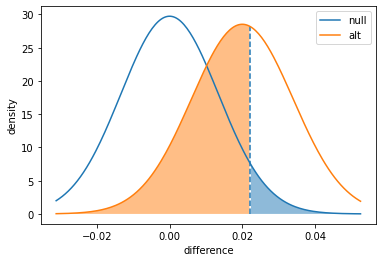

0.44122379261151545

In [17]:
power(p_null=.1, p_alt=.12, n=1000)

In [18]:
assert np.isclose(power(.1, .12, 1000, plot = False), 0.4412, atol = 1e-4)
assert np.isclose(power(.1, .12, 3000, plot = False), 0.8157, atol = 1e-4)
assert np.isclose(power(.1, .12, 5000, plot = False), 0.9474, atol = 1e-4)
print('You should see this message if all the assertions passed!')

You should see this message if all the assertions passed!


## Method 2: Analytic Solution

Now that we've got some intuition for power by using trial and error, we can now approach a closed-form solution for computing a minimum experiment size. The key point to notice is that, for an $\alpha$ and $\beta$ both < .5, the critical value for determining statistical significance will fall between our null click-through rate and our alternative, desired click-through rate. So, the difference between $p_0$ and $p_1$ can be subdivided into the distance from $p_0$ to the critical value $p^*$ and the distance from $p^*$ to $p_1$.

<img src= '01_stat_considerations/images/ExpSize_Power.png'>

Those subdivisions can be expressed in terms of the standard error and the z-scores:

$$p^* - p_0 = z_{1-\alpha} SE_{0},$$
$$p_1 - p^* = -z_{\beta} SE_{1};$$

$$p_1 - p_0 = z_{1-\alpha} SE_{0} - z_{\beta} SE_{1}$$

In turn, the standard errors can be expressed in terms of the standard deviations of the distributions, divided by the square root of the number of samples in each group:

$$SE_{0} = \frac{s_{0}}{\sqrt{n}},$$
$$SE_{1} = \frac{s_{1}}{\sqrt{n}}$$

Substituting these values in and solving for $n$ will give us a formula for computing a minimum sample size to detect a specified difference, at the desired level of power:

$$n = \lceil \big(\frac{z_{\alpha} s_{0} - z_{\beta} s_{1}}{p_1 - p_0}\big)^2 \rceil$$

where $\lceil ... \rceil$ represents the ceiling function, rounding up decimal values to the next-higher integer. Implement the necessary variables in the function below, and test them with the cells that follow.

In [19]:
def experiment_size(p_null, p_alt, alpha = .05, beta = .20):
    """
    Compute the minimum number of samples needed to achieve a desired power
    level for a given effect size.
    
    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected
        alpha : Type-I error rate
        beta  : Type-II error rate
    
    Output value:
        n : Number of samples required for each group to obtain desired power
    """
    
    # Get necessary z-scores and standard deviations (@ 1 obs per group)
    z_null = stats.norm.ppf(1 - alpha)
    z_alt  = stats.norm.ppf(beta)
    sd_null = np.sqrt(p_null * (1-p_null) + p_null * (1-p_null))
    sd_alt  = np.sqrt(p_null * (1-p_null) + p_alt  * (1-p_alt) )
    
    # Compute and return minimum sample size
    p_diff = p_alt - p_null
    n = ((z_null*sd_null - z_alt*sd_alt) / p_diff) ** 2
    return np.ceil(n)

In [58]:
experiment_size(.1, .12)

2863.0

In [18]:
assert np.isclose(experiment_size(.1, .12), 2863)
print('You should see this message if the assertion passed!')

You should see this message if the assertion passed!


## Notes on Interpretation

The example explored above is a one-tailed test, with the alternative value greater than the null. The power computations performed in the first part will *not work* if the alternative proportion is greater than the null, e.g. detecting a proportion parameter of 0.88 against a null of 0.9. You might want to try to rewrite the code to handle that case! The same issue should not show up for the second approach, where we directly compute the sample size.

If you find that you need to do a two-tailed test, you should pay attention to two main things.
* First of all, the $\alpha$ parameter needs to account for the fact that the rejection region is divided into **two areas**
* Secondly, you should perform the computation based on the worst-case scenario, the alternative case with the highest variability. Since, for the binomial, variance is highest when $p = .5$ , decreasing as $p$ approaches 0 or 1, you should choose the alternative value that is closest to .5 as your reference when computing the necessary sample size.

Note as well that the above methods only perform sizing for *statistical significance*, and do not take into account *practical significance*. One thing to realize is that if the true size of the experimental effect is the same as the desired practical significance level, then it's a coin flip whether the mean will be above or below the practical significance bound. This also doesn't even consider how a confidence interval might interact with that bound. In a way, experiment sizing is a way of checking on whether or not you'll be able to get what you *want* from running an experiment, rather than checking if you'll get what you *need*.

## Alternative Approaches

There are also tools and Python packages that can also help with sample sizing decisions, so you don't need to solve for every case on your own. The sample size calculator [here](http://www.evanmiller.org/ab-testing/sample-size.html) is applicable for proportions, and provides the same results as the methods explored above. (Note that the calculator assumes a two-tailed test, however.) Python package "statsmodels" has a number of functions in its [`power` module](https://www.statsmodels.org/stable/stats.html#power-and-sample-size-calculations) that perform power and sample size calculations. Unlike previously shown methods, differences between null and alternative are parameterized as an effect size (standardized difference between group means divided by the standard deviation). Thus, we can use these functions for more than just tests of proportions. If we want to do the same tests as before, the [`proportion_effectsize`](http://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_effectsize.html) function computes [Cohen's h](https://en.wikipedia.org/wiki/Cohen%27s_h) as a measure of effect size. As a result, the output of the statsmodel functions will be different from the result expected above. This shouldn't be a major concern since in most cases, you're not going to be stopping based on an exact number of observations. You'll just use the value to make general design decisions.

In [47]:
# example of using statsmodels for sample size calculation
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# leave out the "nobs" parameter to solve for it
NormalIndPower().solve_power(effect_size = proportion_effectsize(prop1=.12, prop2=.1), 
                             alpha = .05, 
                             power = 0.8,
                             alternative = 'larger')

5.808684339350776

#### Exercise Closing Comments

After computing the number of observations needed for an experiment to reliably detect a specified level of experimental effect (i.e. statistical power), we need to divide by the expected number of observations per day in order to get a minimum experiment length. We want to make sure that an experiment can be completed in a reasonable time frame so that if we do have a successful effect, it can be deployed as soon as possible and resources can be freed up to run new experiments. What a 'reasonable time frame' means will depend on how important a change will be, but if the length of time is beyond a month or two, that's probably a sign that it's too long.

There are a few ways that an experiment's duration can be reduced. We could, of course, change our statistical parameters. Accepting higher Type I or Type II error rates will reduce the number of observations needed. So too will increasing the effect size: it's much easier to detect larger changes.

Another option is to change the unit of diversion. A 'wider' unit of diversion will result in more observations being generated. For example, you could consider moving from a cookie-based diversion in a web-based experiment to an event-based diversion like pageviews. The tradeoff is that event-based diversion could create inconsistent website experiences for users who visit the site multiple times.

# Lesson 4 - Using Dummy Tests

**Dummy Test (aka A/A Test):** An experiment run between equivalent groups (i.e. no experimental group)

When it comes to designing an experiment, it might be useful to run a dummy test as a predecessor to or as part of that process. In a dummy test, you will implement the same steps that you would in an actual experiment to assign the experimental units into groups. However, the experimental manipulation won't actually be implemented, and the groups will be treated equivalently.

There are multiple reasons to run a dummy test:
1. Make sure a dummy test is working as expected
> * Check that each group is receiving an equal number of participants
> * Outcomes of evaluation and invariant metrics both conform to the expectation of seeing no 
> * Type-I Errors happen, so a statistical significance on a single metric may not be a deal breaker, just something to investigate

First, a dummy test can expose if there are any errors in the randomization or assignment procedures. A short dummy test can be worth the investment if an invariant metric is found to have a statistically significant difference, or if some other systematic bias is identified, because it can help avoid larger problems down the line


<center><img src='stat_cons_11.png' width=500></center>

2. if you need to collect information about the behaviors of your metrics in order to scope out the whole design
> * When you may not have reliable historic information to predict the distribution of the outcome metrics, can give insight into how much variablity and experimental result with no effect would look like
> * help with determining how large and how long an experiment needs to be


Second reason to run a dummy test is to collect data on metrics' behaviors. If historic data is not enough to predict the outcome of recorded metrics or allow for experiment duration to be computed, then a dummy test can be useful for getting baselines.
> 

<center><img src='stat_cons_12.png' width=500></center>

Of course, performing a dummy test requires an investment of resources, the most important of which is time. If time is of the essence, then you may need to just go ahead with the experiment, keeping an eye on invariant metrics for any trouble. An alternative approach is to perform a hybrid test. In the A/B testing paradigm, this can take the form of an A/A/B test. That is, we split the data into three groups: two control and one experimental. A comparison between control groups can be used to learn about null-environment properties before making inferences on the effect of the experimental manipulation.

# Lesson 5 - Non-Parametric Tests

Up until now, you've been using standard hypothesis tests on means of normal distributions to design and analyze experiments. However, it's possible that you will encounter scenarios where you can't rely on only standard tests. This might be due to uncertainty about the true variability of a metric's distribution, a lack of data to assume normality, or wanting to do inference on a statistic that lacks a standard test. It's useful to know about some **non-parametric tests**, not just as a workaround for cases like this, but also as a second check on your experimental results. The main benefit of non-parametric tests is that they don't rely on many assumptions of the underlying population, and so can be used in a wider range of circumstances compared to standard tests. In this notebook, you'll cover two non-parametric approaches that use resampling of the data to make inferences about distributions and differences.

## Exercise - Bootstrapping

Bootstrapping is used to estimate sampling distributions by using the actually collected data to generate new samples that could have been hypothetically collected. In a standard bootstrap, a bootstrapped sample means drawing points from the original data *with replacement* until we get as many points as there were in the original data. Essentially, we're treating the original data as the population: without making assumptions about the original population distribution, using the original data as a model of the population is the best that we can do.

Taking a lot of bootstrapped samples allows us to estimate the sampling distribution for various statistics on our original data. For example, let's say that we wanted to create a 95% confidence interval for the 90th percentile from a dataset of 5,000 data points. (Perhaps we're looking at website load times and want to reduce the worst cases.) Bootstrapping makes this easy to estimate.
1. First of all, we take a bootstrap sample (i.e., draw 5000 points with replacement from the original data), record the 90th percentile, and then repeat this a large number of times, let's say 100,000 times.
2. From this bunch of bootstrapped 90th percentile estimates, we form our confidence interval by finding the values that capture the central 95% of the estimates (cutting off 2.5% on each tail). Implement this operation in the cells below, using the following steps:

A. Initialize some useful variables by storing the number of data points in `n_points` and setting up an empty list for the bootstrapped quantile values in `sample_qs`.

B. Create a loop for each trial:
  - First generate a bootstrap sample by sampling from our data with replacement. ([`random.choice`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) will be useful here.)
  - Then, compute the `q`th quantile of the sample and add it to the `sample_qs` list. If you're using NumPy v0.15 or later, you can use the [`quantile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.quantile.html) function to get the quantile directly with `q`; on v0.14 or earlier, you'll need to put `q` in terms of a percentile and use [`percentile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html) instead.
- After gathering the bootstrapped quantiles, find the limits that capture the central `c` proportion of quantiles to form the estimated confidence interval.

In [20]:
def quantile_ci(data, q, c = .95, n_trials = 1000):
    """
    Compute a confidence interval for a quantile of a dataset using a bootstrap
    method.
    
    Input parameters:
        data: data in form of 1-D array-like (e.g. numpy array or Pandas series)
        q: quantile to be estimated, must be between 0 and 1
        c: confidence interval width
        n_trials: number of bootstrap samples to perform
    
    Output value:
        ci: Tuple indicating lower and upper bounds of bootstrapped
            confidence interval
    """
    
    # initialize storage of bootstrapped sample quantiles
    n_points = data.shape[0] # number of data points
    sample_qs = [] # storage of sampled quantiles
    
    # For each trial...
    for _ in range(n_trials):
        # draw a random sample from the data with replacement...
        sample = np.random.choice(data,n_points,replace=True)
        
        # compute the desired quantile...
        sample_q = np.percentile(sample,100*q)
        
        # and add the value to the list of sampled quantiles
        sample_qs.append(sample_q)
        
    # Compute the confidence interval bounds
    lower_limit = np.percentile(sample_qs, (1 - c)/2 * 100) # chop the left side
    upper_limit = np.percentile(sample_qs, (1 + c)/2 * 100) # chop the right side
    
    return (lower_limit, upper_limit)

In [21]:
data = pd.read_csv('01_stat_considerations/data/bootstrapping_data.csv')
data.head()

,time
0,8152
1,2082
2,3049
3,3317
4,813


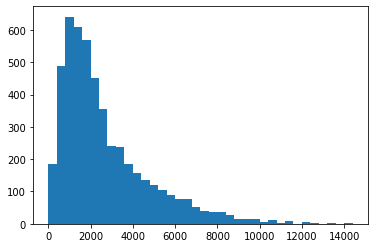

In [22]:
# data visualization
plt.hist(data['time'], bins = np.arange(0, data['time'].max()+400, 400));

In [29]:
lims = quantile_ci(data['time'], 0.9)
print(lims)

(5496.955, 5837.0)


### Bootstrapping Notes

Confidence intervals coming from the bootstrap procedure will be optimistic compared to the true state of the world. This is because there will be things that we don't know about the real world that we can't account for, due to not having a parametric model of the world's state. Consider the extreme case of trying to understand the distribution of the maximum value: our confidence interval would never be able to include any value greater than the largest observed value and it makes no sense to have any lower bound below the maximum observation. Intuitively, however, there's a pretty clear possibility for there to be unobserved values that are larger than the one we've observed, especially for skewed data like shown in the example.

This doesn't override the bootstrap method's advantages, however. The bootstrap procedure is fairly simple and straightforward. Since you don't make assumptions about the distribution of data, it can be applicable for any case you encounter. The results should also be fairly comparable to standard tests. But it does take computational effort, and its output does depend on the data put in. For reference, for the 95% CI on the 90th percentile example explored above, the inferred interval would only capture about 83% of 90th percentiles from the original generating distribution. But a more intricate procedure using a binomial assumption to index on the observed data only does about one percentage point better (84%). And both of these depend on the specific data generated: a different set of 5000 points will produce different intervals, with different accuracies.

Binomial solution for percentile CIs reference: [1](https://www-users.york.ac.uk/~mb55/intro/cicent.htm), [2](https://stats.stackexchange.com/questions/99829/how-to-obtain-a-confidence-interval-for-a-percentile)

## Permutation Tests

The permutation test is a resampling-type test used to compare the values on an outcome variable between two or more groups. In the case of the permutation test, resampling is done on the group labels. The idea here is that, under the null hypothesis, the outcome distribution should be the same for all groups, whether control or experimental. Thus, we can emulate the null by taking all of the data values as a single large group. Applying labels randomly to the data points (while maintaining the original group membership ratios) gives us one simulated outcome from the null.

The rest is similar to the sampling approach used in a standard hypothesis test, except that we haven't specified a reference distribution to sample from – we're sampling directly from the data we've collected. After applying the labels randomly to all the data and recording the outcome statistic many times, we compare our actual, observed statistic against the simulated statistics. A p-value is obtained by seeing how many simulated statistic values are as or more extreme than the one actually observed, and a conclusion is then drawn.

Try implementing a permutation test in the cells below to test if the 90th percentile of times is statistically significantly smaller for the experimental group, as compared to the control group:

- Initialize an empty list to store the difference in sample quantiles as `sample_diffs`.
- Create a loop for each trial:
  - First generate a permutation sample by randomly shuffling the data point labels. ([`random.permutation`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html) will be useful here.)
  - Then, compute the `q`th quantile of the data points that have been assigned to each group based on the permuted labels. Append the difference in quantiles to the `sample_diffs` list.
- After gathering the quantile differences for permuted samples, compute the observed difference for the actual data. Then, compute a p-value from the number of permuted sample differences that are less than or greater than the observed difference, depending on the desired alternative hypothesis.

In [31]:
def quantile_permtest(x, y, q, alternative = 'less', n_trials = 10_000):
    """
    Compute a confidence interval for a quantile of a dataset using a bootstrap
    method.
    
    Input parameters:
        x: 1-D array-like of data for independent / grouping feature as 0s and 1s
        y: 1-D array-like of data for dependent / output feature
        q: quantile to be estimated, must be between 0 and 1
        alternative: type of test to perform, {'less', 'greater'}
        n_trials: number of permutation trials to perform
    
    Output value:
        p: estimated p-value of test
    """
    
    
    # initialize storage of bootstrapped sample quantiles
    sample_diffs = []
    
    # For each trial...
    for _ in range(n_trials):
        # randomly permute the grouping labels
        labels = np.random.permutation(y)
        
        # compute the difference in quantiles
        cond_q = np.percentile(x[labels == 0], 100 * q)
        exp_q  = np.percentile(x[labels == 1], 100 * q)
        
        # and add the value to the list of sampled differences
        sample_diffs.append(exp_q - cond_q)
    
    # compute observed statistic
    cond_q = np.percentile(x[y == 0], 100 * q)
    exp_q  = np.percentile(x[y == 1], 100 * q)
    obs_diff = exp_q - cond_q
    
    # compute a p-value
    if alternative == 'less':
        hits = (sample_diffs <= obs_diff).sum()
    elif alternative == 'greater':
        hits = (sample_diffs >= obs_diff).sum()
    
    return (hits / n_trials)

In [33]:
data = pd.read_csv('01_stat_considerations/data/permutation_data.csv')
data.head()

,condition,time
0,0,5940
1,0,666
2,1,571
3,1,779
4,0,1928


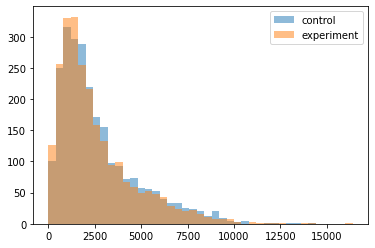

In [34]:
# data visualization
bin_borders = np.arange(0, data['time'].max()+400, 400)
plt.hist(data[data['condition'] == 0]['time'], alpha = 0.5, bins = bin_borders)
plt.hist(data[data['condition'] == 1]['time'], alpha = 0.5, bins = bin_borders)
plt.legend(labels = ['control', 'experiment']);

In [35]:
# Just how different are the two distributions' 90th percentiles?
print(np.percentile(data[data['condition'] == 0]['time'], 90),
      np.percentile(data[data['condition'] == 1]['time'], 90))

5809.2 5492.2


In [40]:
p_val = quantile_permtest(data['time'], data['condition'], 0.9,
                  alternative = 'less')
truthy = None
if p_val >= 0.05:
    truthy = 'True'
else:
    truthy = 'False'
print("The 90th percentile of the two distributions are statistically significantly different: {}".format(truthy))

The 90th percentile of the two distributions are statistically significantly different: False


In [38]:
p_val

0.0347

# Non-Parametric - Exercise 2

Up until now, you've been using standard hypothesis tests on means of normal distributions to design and analyze experiments. However, it's possible that you might encounter scenarios where you can't rely on only standard tests. This might be due to uncertainty about the true variability of a metric's distribution, a lack of data to assume normality, or wanting to do inference on a statistic that lacks a standard test. It's useful to know about some **non-parametric tests** not just as a workaround for cases like this, but also as a second check on your experimental results.

## Rank-Sum Test (Mann-Whitney)

The rank-sum test is fairly different from the two previous approaches. There's no resamplng involved; the test is performed only on the data present. The rank-sum test, also known as the Mann-Whitney U test, is not a test of any particular statistic, like the mean or median. Instead, it's a test of distributions: let's say we draw one value at random from the populations behind each group. The null hypothesis says that there's an equal chance that the larger value is from the first group as the second group; the alternative hypothesis says that there's an unequal chance, which can be specified as one- or two-tailed.

In order to test this hypothesis, we should look at the data we've collected and see in how many cases values from one group win compared to values in the second. That is, for each data point in the first group, we count how many values in the second group that are smaller than it. (If both values are equal, we count that as a tie, worth +0.5 to the tally.) This number of wins for the first group gives us a value $U$.

It turns out that $U$ is approximately normally-distributed, given a large enough sample size. If we have $n_1$ data points in the first group and $n_2$ points in the second, then we have a total of $n_1 n_2$ matchups and an equivalent number of victory points to hand out. Under the null hypothesis, we should expect the number of wins to be evenly distributed between groups, and so the expected wins are $\mu_U = \frac{n_1 n_2}{2}$. The variability in the number of wins can be found to be the following equation (assuming no or few ties):

$$ 
\sigma_U = \sqrt{\frac{n_1n_2(n_1+n_2+1)}{12}}
$$

These $\mu_U$ and $\sigma_U$ values can then be used to compute a standard normal z-score, which generates a p-value. Implement this method of performing the rank-sum test in the cells below!

- HINT: scipy stats' [`norm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) class can be used to obtain p-values after computing a z-score.

In [45]:
def ranked_sum(x, y, alternative = 'two-sided'):
    """
    Return a p-value for a ranked-sum test, assuming no ties.
    
    Input parameters:
        x: 1-D array-like of data for first group
        y: 1-D array-like of data for second group
        alternative: type of test to perform, {'two-sided', less', 'greater'}
    
    Output value:
        p: estimated p-value of test
    """
    
    # compute U
    u = 0
    for i in x:
        x_beat_y = (i > y).sum()
        ties = (i == y).sum() * 0.5
        u += x_beat_y + ties
    
    # compute a z-score
    n_1 = x.shape[0]
    n_2 = y.shape[0]
    mean_u = (n_1 * n_2) / 2 # expected value for U statistic
    numerator = n_1 * n_2 * (n_1 + n_2 + 1)
    sd_u = np.sqrt(numerator / 12) # expected standard deviation for U statistic
    z = (u - mean_u) / sd_u # U value z-score
    
    # compute a p-value
    if alternative == 'two-sided':
        p = 2 * stats.norm.cdf(-np.abs(z))
    if alternative == 'less':
        p = stats.norm.cdf(z)
    elif alternative == 'greater':
        p = stats.norm.cdf(-z)
    
    return p

In [46]:
data = pd.read_csv('01_stat_considerations/data/permutation_data.csv')
data.head()

,condition,time
0,0,5940
1,0,666
2,1,571
3,1,779
4,0,1928


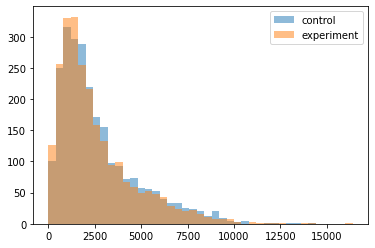

In [47]:
# data visualization
bin_borders = np.arange(0, data['time'].max()+400, 400)
plt.hist(data[data['condition'] == 0]['time'], alpha = 0.5, bins = bin_borders)
plt.hist(data[data['condition'] == 1]['time'], alpha = 0.5, bins = bin_borders)
plt.legend(labels = ['control', 'experiment']);

In [48]:
ranked_sum(data[data['condition'] == 0]['time'],
           data[data['condition'] == 1]['time'],
           alternative = 'greater')

0.001752226502296106

### Rank-Sum Test Notes

For smaller sample sizes, something like the permutation test can be performed. After exhaustively checking the distribution of victories for every possible assignment of group labels to value, a p-value can be computed for how unusual the actually-observed $U$ was.

Also, there already exists a function in the scipy stats package [`mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) that performs the Mann Whitney U test. This function considers more factors than the implementation above, including a correction on the standard deviation for ties and a continuity correction (since we're approximating a discretely-valued distribution with a continuous one). In addition, the approach they take is computationally more efficient, based on the sum of value ranks (hence the rank-sum test name) rather than the matchups explanation provided above.

Reference: [Wikipedia](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)



In [49]:
stats.mannwhitneyu(data[data['condition'] == 0]['time'],
                   data[data['condition'] == 1]['time'],
                   alternative = 'greater')

MannwhitneyuResult(statistic=3273546.0, pvalue=0.001752280226004597)

## Sign Test

The sign test also only uses the collected data to compute a test result. It only requires that there be paired values between two groups to compare, and tests whether one group's values tend to be higher than the other's.

In the sign test, we don't care how large differences are between groups, only which group takes a larger value. So comparisons of 0.21 vs. 0.22 and 0.21 vs. 0.31 are both counted equally as a point in favor of the second group. This makes the sign test a fairly weak test, though also a test that can be applied fairly broadly. It's most useful when we have very few observations to draw from and can't make a good assumption of underlying distribution characteristics. For example, you might use a sign test as an additional check on click rates that have been aggregated on a daily basis.

The count of victories for a particular group can be modeled with the binomial distribution. Under the null hypothesis, it is equally likely that either group has a larger value (in the case of a tie, we ignore the comparison): the binomial distribution's success parameter is $p = 0.5$ . Implement the sign test in the function below!

- HINT: scipy stats' [`binom`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html) class can be used to obtain p-values after computing the number of matchups and victories.

In [50]:
def sign_test(x, y, alternative = 'two-sided'):
    """
    Return a p-value for a ranked-sum test, assuming no ties.
    
    Input parameters:
        x: 1-D array-like of data for first group
        y: 1-D array-like of data for second group
        alternative: type of test to perform, {'two-sided', less', 'greater'}
    
    Output value:
        p: estimated p-value of test
    """
    
    # compute parameters
    n = x.shape[0] - (x == y).sum() # number of matchups
    k = (x > y).sum() - (x == y).sum() # number of victories for first group

    # compute a p-value
    if alternative == 'two-sided':
        p = min(1, 2 * stats.binom(n, 0.5).cdf(min(k, n-k)))
    if alternative == 'less':
        p = stats.binom(n, 0.5).cdf(k)
    elif alternative == 'greater':
        p = stats.binom(n, 0.5).cdf(n-k)
    
    return p

In [52]:
data = pd.read_csv('01_stat_considerations/data/signtest_data.csv')
data.head()

,day,control,exp
0,1,0.09610,0.09715
1,2,0.07357,0.06954
2,3,0.10030,0.08782
3,4,0.07225,0.06936
4,5,0.06173,0.09893


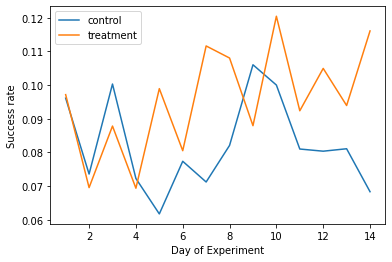

In [57]:
# data visualization
plt.plot(data['day'], data['control'], label='control')
plt.plot(data['day'], data['exp'], label='treatment')
plt.legend()

plt.xlabel('Day of Experiment')
plt.ylabel('Success rate');

In [58]:
sign_test(data['control'], data['exp'], 'less')

0.08978271484375

# Lesson 6 - Analyzing Multiple Metrics

If you have multiple evaluation metrics to track in your experiment, you should be careful to specify the criteria for calling your experiment a success so that you don't make exessive errors in your judgement.

**How likely are we to make an error?**
How likely are we to falsely declare some kind of significant effect if we have two metrics, each set up with a 5% Type I error rate?
$$p\left(metric\ one\ not\ significant \right) and\ p\left(metric\ two\ not\ significant \right) = \left(0.95\right)\cdot\left(0.95\right) = 0.9025$$
$$\rightarrow p\left(at\ least\ one\ metric\ not\ signficiant \right) = 1 - \left(metric\ one\ not\ significant \right) and\ p\left(metric\ two\ not\ significant \right) = 1 - 0.9025 = 0.0975$$

<center><img src='stat_cons_13.png' width=500></center>

If you're tracking multiple evaluation metrics, make sure that you're aware of how the Type I error rates on individual metrics can affect the overall chance of making some kind of Type I error. The simplest case we can consider is if we have _n_ independent evaluation metrics, and that seeing one with a statistically significant result would be enough to call the manipulation a success. In this case, the probability of making at least one Type I error is given by $\alpha_{over} = 1 - (1-\alpha_{ind})^{n}$, illustrated in the below image for individual $\alpha_{ind} =.05$ and $\alpha_{ind} = .01$:

<center><img src='stat_cons_14.png'></center>

To protect against this, we need to introduce a correction factor on the individual test error rate so that the overall error rate is at most the desired level. A conservative approach is to divide the overall error rate by the number of metrics tested:
$$\alpha_{ind}= \frac{\alpha_{over}}{n}$$

This is known as the **Bonferroni correction**. If we assume independence between metrics, we can do a little bit better with the **Šidák correction**:
$$\alpha_{ind}=1-\left(1-\alpha_{over}\right)^{\frac{1}{n}}$$

<center><img src='stat_cons_15.png'></center>

The Šidák correction is only slightly higher than the line drawn by the Bonferroni correction.

In real life, evaluation scenarios are rarely so straightforward. Metrics will likely be correlated in some way, rather than being independent. If a positive correlation exists, then knowing the outcome of one metric will make it more likely for a correlated metric to also point in the same way. In this case, the corrections above will be more conservative than necessary, resulting in an overall error rate smaller than the desired level. (In cases of negative correlation, the true error rate could go either way, depending on the types of tests performed.)

In addition, we might need multiple metrics to show statistical significance to call an experiment a success, or there may be different degrees of success depending on which metrics appear to be moved by the manipulation. One metric may not be enough to make it worth deploying a change tested in an experiment. Reducing the individual error rate will make it harder for a truly significant effect to show up as statistically significant. That is, reducing the Type I error rate will also increase the Type II error rate – another conservative shift.

Ultimately, there is a small balancing act when it comes to selecting an error-controlling scheme. Being fully conservative with one of the simple corrections above means that you increase the risk of failing to roll out changes that actually have an impact on metrics. Consider the level of dependence between metrics and what results are needed to declare a success to calibrate the right balance in error rates. If you need to see a significant change in all of your metrics to proceed with it, you might not need a correction factor at all. You can also use dummy test results, bootstrapping, and permutation approaches to plan significance thresholds. Finally, don't forget that practical significance can be an all-important quality that overrides other statistical significance findings.

While the main focus of this page has been on interpretation of evaluation metrics, it's worth noting that these cautions also apply to invariant metrics. The more invariant metrics you test, the more likely it will be that some test will show a statistically significant difference even if the groups tested are drawn from equivalent populations. However, it might not be a good idea to apply a correction factor to individual tests since we want to avoid larger issues with interpretation later on. As mentioned previously, a single invariant metric showing a statistically significant difference is not necessarily cause for alarm, but it is something that merits follow-up in case it does have an effect on our analysis.

# Early Stopping - Exercise 3

If you peek at the results of an experiment before data collection is complete, and choose to stop early because the test is showing statistical significance, you run the risk of a significant increase in your Type I error rate: believing that your experiment had an effect, when in fact it did not. In this notebook, you'll duplicate the assertions made in the video: namely that for an experiment based off of a single traditional statistical test, doing a single peek halfway through the run-time will increase a base Type I error rate from 5% to about 8.6%.

The simulation function below uses a bernoulli / binomial success model for the outcome metric, measuring against a historic baseline. That is, each observation is a single coin flip with success probability "p". If we see a number of successes that is unusual for our baseline value of "p", then we declare a statistically significant result. We will divide the experiment length into multiple 'blocks', checking the status of the experiment after each block is complete. Our outputs of interest are the proportion of trials that are statistically significant in _any_ test, and the proportion of trials that are statistically significant after _each_ individual block.

There are three main steps to filling out the `peeking_sim()` function.

1. Simulate some data
 - Compute the number of trials per block. For simplicity, just round up any fractions so that each block has the same number of trials: we might end up with slightly more trials per block than the corresponding function parameter.
 - Generate a data matrix with the number of successes observed in each block: the number of rows should be the number of simulations and the number of columns the number of blocks. You can do this with a single call to numpy's [`random.binomial`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.binomial.html) function.
2. Compute z-scores at each 'peek'
 - For each row, compute the cumulative number of successes after each 'block' of the experiment using numpy's [`cumsum`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html) function. The result should be a matrix with the same dimensions as the data, but each column cumulatively adds up the values in each row up to that point.
 - Compute the expected mean and standard deviation for the number of successes after each 'block' of the experiment. Remember that this will be based on the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) and is centered on the raw counts, rather than proportion of successes. It'll be useful to create a vector with the cumulative sum of trials after each block to facilitate these calculations.
 - Use the cumulative counts, the expected counts, and the standard deviations, to compute the z-scores for each peek at the experiment.
3. Aggregate test outcomes
 - Compute a critical z-value using the supposed Type I error rate. Use this critical value to flag which of the z-scores would be counted as statistically significant, and which would not.
 - The proportion of trials that are significant at _any_ test will be the proportion of rows that have at least one flagged value. The proportion of trials that are significant at _each_ block will be the mean number of flagged values in each column; this will be a 1-d array. Return both of these values as the output of the function.

In [59]:
def peeking_sim(alpha = .05, p = .5, n_trials = 1000, n_blocks = 2, n_sims = 10000):
    """
    This function simulates the rate of Type I errors made if an early
    stopping decision is made based on a significant result when peeking ahead.
    
    Input parameters:
        alpha: Supposed Type I error rate
        p: Probability of individual trial success
        n_trials: Number of trials in a full experiment
        n_blocks: Number of times data is looked at (including end)
        n_sims: Number of simulated experiments run
        
    Return:
        p_sig_any: Proportion of simulations significant at any check point, 
        p_sig_each: Proportion of simulations significant at each check point
    """
    
    # generate data
    trials_per_block = np.ceil(n_trials / n_blocks).astype(int) # Round-up
    data = np.random.binomial(n=trials_per_block, p=p, size=[n_sims, n_blocks]) # Random generated data from bernoulli of shape n_sims by n_blocks
    
    # standardize data
    data_cumsum = np.cumsum(data, axis = 1)
    block_sizes = trials_per_block * np.arange(1, n_blocks+1, 1)
    block_means = block_sizes * p
    block_sds   = np.sqrt(block_sizes * p * (1-p))
    data_zscores = (data_cumsum - block_means) / block_sds
    
    # test outcomes
    z_crit = stats.norm.ppf(1-alpha/2) # two sided
    sig_flags = np.abs(data_zscores) > z_crit
    p_sig_any = (sig_flags.sum(axis = 1) > 0).mean()
    p_sig_each = sig_flags.mean(axis = 0)
    
    return (p_sig_any, p_sig_each)
    

Running the function on the default parameters as given should return a tuple of results where the probability of any significant test outcome across the two blocks is around 8.6% and the probability of a significant test outcome at each individual block checkpoint is around 5%. Increase the number of trials and number of simulations to get more accurate estimates. You should also see how the overall Type I error rate increases with additional peeks!

In [63]:
peeking_sim(n_trials=100000, n_sims=100000)

(0.08389, array([0.0511 , 0.05084]))

### A Multiple Comparisons Approach to Early Peeking
The safest way we could deal with performing multiple checks and making poor early stopping decisions is to simply not do it. Once an experiment has been planned and all assignment procedures checked, you should just let the experiment run to completion and just assess the results at the very end. That's not to say that you can't perform early stopping, but it does require additional planning.

One way in which you could solve for multiple peeking is to adjust the significance level of individual tests so that the overall error rate is at its desired level. But applying the Bonferroni or Šidák corrections as shown earlier in the lesson will definitely be too conservative, since we know that there is a correlation in test results between peeks. If we see some simulated run with z-score above the threshold at the halfway point, it's more likely to be above that threshold at the end point, compared to some other simulated run that is not statistically significant at the halfway point. One way in which we can obtain a better significance threshold is through the power of simulation. After performing the same steps 1 and 2 above, we want to find a significance level that would call our desired proportion of simulated tests as statistically significant:

Simulate some data (as above)
Compute z-scores at each 'peek' (as above)
Obtain required individual-test error rate
A run is considered statistically significant if it exceeds the critical bounds at any peek. Obtain the maximum z-score from each row as a worst-case scenario for a null run to be falsely rejected.
Find the z-score threshold that would reject our desired overall Type I error rate.
Convert that z-score into an equivalent individual-test error rate.

In [64]:
def peeking_correction(alpha = .05, p = .5, n_trials = 1000, n_blocks = 2, n_sims = 10000):
    """
    This function uses simulations to estimate the individual error rate necessary
    to limit the Type I error rate, if an early stopping decision is made based on
    a significant result when peeking ahead.
    
    Input parameters:
        alpha: Desired overall Type I error rate
        p: Probability of individual trial success
        n_trials: Number of trials in a full experiment
        n_blocks: Number of times data is looked at (including end)
        n_sims: Number of simulated experiments run
        
    Return:
        alpha_ind: Individual error rate required to achieve overall error rate
    """
    
    # generate data
    trials_per_block = np.ceil(n_trials / n_blocks).astype(int)
    data = np.random.binomial(trials_per_block, p, [n_sims, n_blocks])
    
    # standardize data
    data_cumsum = np.cumsum(data, axis = 1)
    block_sizes = trials_per_block * np.arange(1, n_blocks+1, 1)
    block_means = block_sizes * p
    block_sds   = np.sqrt(block_sizes * p * (1-p))
    data_zscores = (data_cumsum - block_means) / block_sds
    
    # find necessary individual error rate
    max_zscores = np.abs(data_zscores).max(axis = 1)
    z_crit_ind = np.percentile(max_zscores, 100 * (1 - alpha))
    alpha_ind = 2 * (1 - stats.norm.cdf(z_crit_ind))
    
    return alpha_ind

Running the function on the default parameters should give a required individual error rate of about .029. Note how this is somewhat higher than the .025 or .0253 that would have been generated from the Bonferroni and Šidák corrections, respectively. Test with a higher number of simulations and trials to get more accurate estimates, and try out different numbers of blocks to see how it changes the individual error rate needed. The results should approximately match up with the numbers given in the table in the middle of this article; note that peeking $n$ times means splitting the experiment into $n+1$  blocks.

In [66]:
peeking_correction(n_trials=10000, n_sims=100000)

0.02941431013863638

# Conclusions

**Statistical Considerations in Testing:**
* Practical Significance
* Experiment Sizing
* Performing Dummy Tests
* Analyzing Multiple Metrics
* Early Stopping